In [107]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [108]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
df = pd.read_csv(
    Path("yen.csv"), parse_dates=True, index_col='Date')

df.head()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [109]:
# Trim the dataset to begin on January 1st, 1990
df = df.loc["1990-01-01":, :]

df.dropna(inplace=True)
df

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0
...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0


# Data Preparation

### Returns

In [127]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

df['Return'] = df.Settle.pct_change()


df['Return'].head()


C:\Users\selprince.AGCO\AppData\Local\Continuum\anaconda3NEW\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Date
2014-02-20         NaN
2014-02-21   -0.002046
2014-02-24    0.000205
2014-02-25    0.003280
2014-02-26   -0.002963
Name: Return, dtype: float64

### Lagged Returns 

In [128]:
# Create a lagged return using the shift function
df['Lagged_Return'] = df.Return.shift()
df = df.dropna()
df

C:\Users\selprince.AGCO\AppData\Local\Continuum\anaconda3NEW\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.000205,-0.002046
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.003280,0.000205
2014-02-26,9784.0,9795.0,9746.0,9760.0,29.0,9760.0,118559.0,200105.0,-0.002963,0.003280
2014-02-27,9769.0,9831.0,9762.0,9798.0,38.0,9798.0,160638.0,201246.0,0.003893,-0.002963
2014-02-28,9787.0,9848.0,9776.0,9825.0,27.0,9825.0,169374.0,200184.0,0.002756,0.003893
...,...,...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.004106,0.001709
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.003695,-0.004106
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.005643,-0.003695


### Train Test Split

In [129]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = df['1990':'2018']

test = df['2018':'2019']

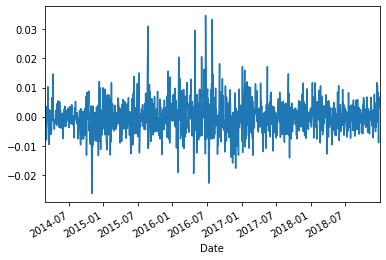

In [130]:
train.Return.plot()

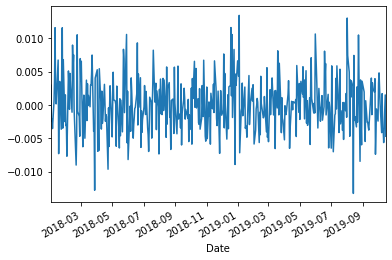

In [131]:
test.Return.plot()

In [132]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]
df.dropna()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.000205,-0.002046
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.003280,0.000205
2014-02-26,9784.0,9795.0,9746.0,9760.0,29.0,9760.0,118559.0,200105.0,-0.002963,0.003280
2014-02-27,9769.0,9831.0,9762.0,9798.0,38.0,9798.0,160638.0,201246.0,0.003893,-0.002963
2014-02-28,9787.0,9848.0,9776.0,9825.0,27.0,9825.0,169374.0,200184.0,0.002756,0.003893
...,...,...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.004106,0.001709
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.003695,-0.004106
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.005643,-0.003695


In [133]:
X_train

,Lagged_Return
Date,
2014-02-24,-0.002046
2014-02-25,0.000205
2014-02-26,0.003280
2014-02-27,-0.002963
2014-02-28,0.003893
...,...
2018-12-24,-0.001875
2018-12-26,0.008345
2018-12-27,-0.008933


In [134]:
X_test

,Lagged_Return
Date,
2018-01-02,0.002249
2018-01-03,0.002973
2018-01-04,-0.002405
2018-01-05,-0.002130
2018-01-08,-0.003539
...,...
2019-10-09,0.001709
2019-10-10,-0.004106
2019-10-11,-0.003695


In [135]:
y_train

Date
2014-02-24    0.000205
2014-02-25    0.003280
2014-02-26   -0.002963
2014-02-27    0.003893
2014-02-28    0.002756
                ...   
2018-12-24    0.008345
2018-12-26   -0.008933
2018-12-27    0.004645
2018-12-28    0.002972
2018-12-31    0.006641
Name: Return, Length: 1215, dtype: float64

In [136]:
y_test

Date
2018-01-02    0.002973
2018-01-03   -0.002405
2018-01-04   -0.002130
2018-01-05   -0.003539
2018-01-08    0.000620
                ...   
2019-10-09   -0.004106
2019-10-10   -0.003695
2019-10-11   -0.005643
2019-10-14    0.001513
2019-10-15   -0.004695
Name: Return, Length: 448, dtype: float64

# Linear Regression Model

In [137]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [138]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [139]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Laggered_Return"] = predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017CAFE16408>,
      dtype=object)

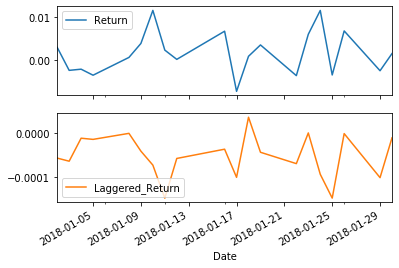

In [140]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [141]:


from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 

mse = mean_squared_error(
    Results["Return"],
    Results["Laggered_Return"]
)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.004152118225942089


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [144]:
#in_sample_results["Return"] = in_sample_results["Return"] / 100

# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train) *100

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.008615229491832539


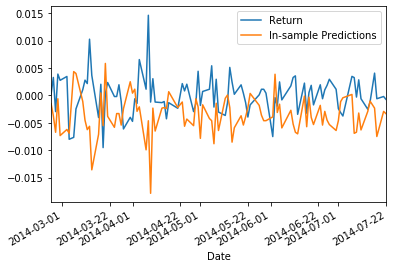

In [145]:
in_sample_results[:100].plot()

# Conclusions

YOUR CONCLUSIONS HERE!

In conclusion:
When comparing the predectided vs actual the data proves to be unreliable. We have a small MRSE but the predicted results dont mirror actual. The direction of the spikes are weird in some place.